In [1]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [2]:
#|export
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from geopy.geocoders import Nominatim
import os,glob

from dementia_inequalities.tools.health_helpers import polygon_area 

In [3]:
N_intersections = 100

In [4]:
# population_data_path = 'data/LAD_populations/LAD_population2019.csv'
# QOF_data_path = 'data/QOF/qof_2019_20.csv'
# GP_catchment_areas_geo_path = 'data/GP_catchment_areas/eDecJan-Mar2020.geojson'
# LAD_geo_path = 'data/LAD_boundaries/Lower_Layer_Super_Output_Areas_Dec_2011/Lower_Layer_Super_Output_Areas_(December_2011)_Boundaries_Generalised_Clipped_(BGC)_EW_V3.shp'

In [5]:
# Load geojson files of boundaries
gdf_LAD = gpd.read_file(const.data_path+'/LAD_area/LAD_Dec_2021_GB_BFC_2022_-8975151699474964544.geojson')
#LAD_data.to_crs(epsg=4326, inplace=True)

gdf_catchment = gpd.read_file(const.data_path+'/Catchment Area/A81001.geojson')
for filename in glob.glob(os.path.join(const.data_path+'/Catchment Area/', '*.geojson')):
  gdf_catchment = pd.concat([gdf_catchment, gpd.read_file(filename)])

gdf_catchment = gdf_catchment.to_crs(epsg=3857)
gdf_LAD = gdf_LAD.to_crs(epsg=3857)

In [6]:
gdf_catchment.rename(columns={'name': 'Name'}, inplace=True)
# get rid of those whose surgeries are un-named
gdf_catchment = gdf_catchment[gdf_catchment['Name'].notna()]

# tidy gp catchment area dataframe 
gdf_catchment.reset_index(inplace=True)


Remove the worst data entry errors in the GP catchment areas 

In [7]:
areas = []
areas_with_index = []
for i in range(len(gdf_catchment['geometry'])):
    area = polygon_area(gdf_catchment['geometry'][i])
    areas.append(area)
    areas_with_index.append( (i, area) )
areas_with_index.sort(key=lambda d: d[1])

gdf_catchment['area'] = areas

In [8]:
for i, area in areas_with_index[-10:]:
    name = gdf_catchment.iloc[i].Name
    print('(%s) %s: %se9' % (i, name, np.round(area/1e9,2)))

(7484) P81042 - ADELAIDE STREET SURGERY: 587723.9e9
(7826) P81042001 - DR ANDERSON AND PARTNERS: 587723.9e9
(7263) P88025 - HULME HALL MEDICAL GROUP: 591219.76e9
(810) C88049001 - ECCLESFIELD ROAD SURGERY: 635632.94e9
(4390) C88049 - ELM LANE SURGERY: 635632.94e9
(5093) F83673 - THE MEDICAL CENTRE: 751792.51e9
(4447) F85063 - THE MUSWELL HILL PRACTICE: 798453.02e9
(6828) J83625 - LODGE SURGERY: 801778.95e9
(8484) G85052 - OLD KENT ROAD SURGERY: 946497.86e9
(3080) H81644 - FOUNTAIN PRACTICE: 1183545.61e9


In [9]:
# This is the other catchment area that needs to removed 
gdf_catchment[gdf_catchment['Name'].str.contains("LANCELOT MEDICAL CENTRE")]

,index,stroke-opacity,Name,Region,SubICBCode,ICBCode,ODSCode,fill-opacity,stroke,OrgLongitude,OrgLatitude,geometry,DCORegion,CCGCode,area
946,0,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-114376.658 6965691.189, -125582.635...",NaN,NaN,-3.570936e+14
947,1,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-1383669.433 7552858.586, -1396446.3...",NaN,NaN,-6.435954e+14
948,2,1.0,LANCELOT MEDICAL CENTRE,NaN,NaN,NaN,E84063,0.0,#0000FF,NaN,NaN,"POLYGON ((-114503.896 6963909.706, -120191.877...",NaN,NaN,1.874673e+14


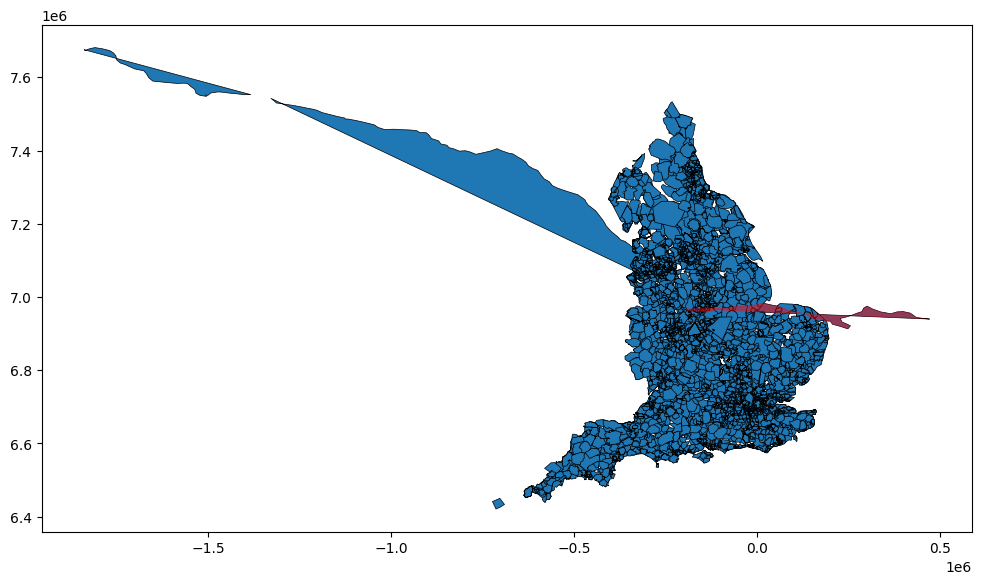

In [10]:
i = areas_with_index[-7][0]
fig, ax = plt.subplots(figsize=(12,10))
gdf_catchment.plot(ax=ax, edgecolor='black', linewidth=0.5, alpha=1.0)
gdf_catchment.loc[[948],'geometry'].plot(ax=ax, color='red', alpha=0.5)
plt.show()

In [11]:
gdf_catchment = gdf_catchment.to_crs(epsg=3857)
gdf_LAD = gdf_LAD.to_crs(epsg=3857)

<Axes: >

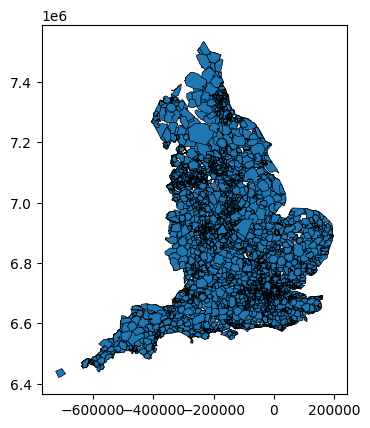

In [12]:
gdf_catchment = gdf_catchment.drop([948, 947, 946, 7138])
gdf_catchment.plot(edgecolor='black', linewidth=0.5)

**Note to Bea** That GP catchment area off the end of cornwall is fine - you forgot the Isles of Scilly... 

In [13]:
population_data_path = const.output_path + '/LAD_age_2021.csv'
df_pop = pd.read_csv(population_data_path)
df_pop = df_pop[['LAD_name', 'all_age']]

In [14]:
# Change to lon lat
gdf_LAD = gdf_LAD.to_crs(epsg=4326)
# Remove Wales
gdf_LAD = gdf_LAD.drop(gdf_LAD[gdf_LAD['LAD21CD'].str.startswith('W')].index)
# Add population
gdf_LAD = gdf_LAD.merge(df_pop, left_on='LAD21NM', right_on='LAD_name')

In [15]:
# # Merge with QOF data to ensure that we don't use GPs that have no QOF data
# unmerged_gdf_catchment = gdf_catchment
# gdf_catchment = unmerged_gdf_catchment.merge(df_QOF, left_on='ODSCode', right_on='pcode')

In [16]:
merc_gdf_catchment = gdf_catchment.to_crs(epsg=3857)
merc_gdf_LAD = gdf_LAD.to_crs(epsg=3857)

Compute intersections $A_{ik}$ between LADs $i$ and GP $k$ catchment areas. 

In [17]:
###### my version ######

# Compute intersections between LADs and GP catchment areas

merc_gdf_catchment['area'] = merc_gdf_catchment.area / 1000000
merc_gdf_LAD['area'] = merc_gdf_LAD.area / 1000000

LAD_GP_catchment_area_interesections = []

GP_xs = np.array(merc_gdf_catchment['geometry'].centroid.x)
GP_ys = np.array(merc_gdf_catchment['geometry'].centroid.y)

for i, LAD_row in merc_gdf_LAD.iterrows():
    #print('LAD %s/%s' % (i+1, merc_gdf_LAD.shape[0]), end='\r')
    
    LAD_center = LAD_row.geometry.centroid
    dx = GP_xs - LAD_center.x
    dy = GP_ys - LAD_center.y
    dists = np.sqrt(dx**2 + dy**2)
    #closest_GPs = merc_gdf_catchment.index[dists.argsort()[:N_intersections]]
    closest_GPs = merc_gdf_catchment.index[dists.argsort()[:N_intersections]]
    print(closest_GPs)
    
    inters = []
    _intersection_areas = []
    for j in closest_GPs:
        inter = merc_gdf_catchment.loc[j].geometry.buffer(0).intersection(LAD_row.geometry).area
        inter = inter / 1000000
        inters.append(inter)
        if inter != 0:
            _intersection_areas.append([j, inter])


#print(merc_gdf_catchment.loc[7232].area)
#print(merc_gdf_LAD.iloc[0].area)
#print(merc_gdf_catchment.loc[7232].geometry.intersection(merc_gdf_LAD.iloc[0].geometry).area)
#print(merc_gdf_LAD.iloc[0].overlay(merc_gdf_catchment.loc[7232], how='intersection'))
#int = merc_gdf_catchment.loc[7232].geometry.buffer(0).intersection(merc_gdf_LAD.iloc[0].geometry).area / 1000000
#print(int/merc_gdf_LAD.iloc[0].area) 

    #gdf_inters = gpd.GeoDataFrame({ 'geometry' : inters })
    #gdf_inters = gdf_inters.to_crs(epsg=4326)
    #gdf_inters.crs = {'init': 'epsg:3857', 'no_defs': True}

    # _intersection_areas = []
    
    # for k, j in enumerate(closest_GPs):
    #     inter = inters[k]
    #     if inter.area != 0:
    #         _intersection_areas.append(inter)
    #         #_intersection_areas.append(inter)
            
    LAD_GP_catchment_area_interesections.append(_intersection_areas)
    

Index([7232, 1610, 7223, 7963, 2657, 4877, 1921, 8900, 6066, 8901, 8647, 1611,
       4835, 4834, 8899, 2776, 3312, 1131, 6057, 6035, 9784,  266, 4833, 6543,
       4809, 7845, 4801, 1129,   35, 1130, 4812, 4802, 4831, 1902, 4803, 4811,
       4830, 4829,  599, 7231, 5295, 3152, 8152, 9552, 5303, 1569, 6849, 4813,
       4810, 4814, 4805,  602,  877, 4815, 6393, 6160, 8895,    0, 4828, 4886,
        871, 2984, 4816, 7539, 3806, 2444, 1933, 4808, 4817, 7862, 4806, 3321,
       4858,  600, 1138, 4857, 3119, 3836, 1904, 9804, 6535, 6859,  864, 2967,
       1905, 3875, 7527, 4844, 4323, 3117, 3118, 4818, 4859, 4807, 3881, 7955,
       3120, 2792, 4827,  601],
      dtype='int64')
Index([4323, 4844, 3875, 3881, 2967, 1905, 7527, 4857, 1138, 7862, 6859, 2444,
        864, 7539, 3120, 1188, 7982,  601, 3321, 4858, 4859,  600, 1904, 3119,
       4886,  599, 4813, 1903,  602, 4814, 1902, 2653, 4815, 2984, 8413, 1933,
       4936, 6831, 4816, 4805, 4832, 4817, 4818, 4803, 4806, 3118, 1130, 4802,

In [18]:
LAD_GP_catchment_area_interesections

[[[7232, 154.81084533716708],
  [1610, 168.86601043489281],
  [7223, 185.28498667506534],
  [7963, 189.60302197291062],
  [2657, 214.43615125571418],
  [4877, 205.85797876224507],
  [1921, 169.22927289128143],
  [8900, 146.9007454879619],
  [6066, 165.8529127532365],
  [8901, 1.3859965752148822],
  [8647, 181.03554560682124],
  [1611, 35.90296664994265],
  [4835, 0.14845938555753035],
  [8899, 2.0507976344427394],
  [2776, 28.950216305437117],
  [3312, 28.950216305437117],
  [1131, 0.3850899095433539],
  [6057, 3.3372006840025574],
  [6035, 13.276647451350225],
  [9784, 4.14582548490908],
  [266, 1.8595415225017464],
  [6543, 2.520885349041121],
  [7845, 0.908386233470876],
  [35, 9.594586392391566],
  [7231, 22.425373252555787],
  [8152, 1.870836931303561],
  [9552, 0.469243115457781],
  [5303, 12.27596548323491],
  [877, 2.8081094817655625],
  [6393, 12.437541060619909],
  [871, 0.7527715893089224]],
 [[4323, 144.0829613374417],
  [4844, 103.82820521579266],
  [3875, 97.6350778232175

In [19]:
gdf_catchment.iloc[0]
gdf_LAD

,OBJECTID,LAD21CD,LAD21NM,LAD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,LAD_name,all_age
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.67614,cb7275ce-d16e-45f7-8e7d-33032fb9df9d,"MULTIPOLYGON (((-1.22470 54.62611, -1.22493 54...",Hartlepool,92612.0236
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.54467,6598062e-357c-4e8d-b117-5d6de45f75b7,"MULTIPOLYGON (((-1.27720 54.54784, -1.27721 54...",Middlesbrough,143626.7926
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.56752,b23f8b9b-4d88-4c21-80d6-8041e2910ef2,"MULTIPOLYGON (((-1.20098 54.57763, -1.20030 54...",Redcar and Cleveland,136555.2327
3,4,E06000004,Stockton-on-Tees,,444940,518183,-1.30664,54.55691,64624aef-6611-4e3c-bba8-870b0b889e1d,"MULTIPOLYGON (((-1.27211 54.55337, -1.27213 54...",Stockton-on-Tees,197111.0831
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.53534,310b13b3-f45f-452b-88f1-ddd48c1992f5,"POLYGON ((-1.63768 54.61714, -1.63767 54.61670...",Darlington,108221.2509
...,...,...,...,...,...,...,...,...,...,...,...,...
304,305,E09000029,Sutton,,527357,163639,-0.17226,51.35755,2c04baaf-d129-4440-b033-4e9e6935ba0f,"POLYGON ((-0.17473 51.39337, -0.17471 51.39336...",Sutton,209365.9840
305,306,E09000030,Tower Hamlets,,536340,181452,-0.03647,51.51554,855a9b25-e078-4084-b369-ef8f1fbf56ca,"MULTIPOLYGON (((-0.07922 51.50789, -0.07937 51...",Tower Hamlets,312128.6103
306,307,E09000031,Waltham Forest,,537328,190278,-0.01880,51.59461,8cf59aaa-3cec-43e8-898e-ac4c0b122a45,"POLYGON ((-0.00798 51.64632, -0.00760 51.64622...",Waltham Forest,277949.2316
307,308,E09000032,Wandsworth,,525152,174138,-0.20021,51.45240,3663eaf3-7734-4281-b40f-16a0a23b385f,"POLYGON ((-0.12825 51.48485, -0.12815 51.48473...",Wandsworth,328248.0472


In [20]:
gdf_catchment.iloc[7232]

index                                                             0
stroke-opacity                                                  1.0
Name                                      L82051002 - BUGLE SURGERY
Region                                                          Y58
SubICBCode                                                      11N
ICBCode                                                         QT6
ODSCode                                                   L82051002
fill-opacity                                                    0.0
stroke                                                      #FF901E
OrgLongitude                                                       
OrgLatitude                                                        
geometry          POLYGON ((-550958.0085627807 6511823.410195558...
DCORegion                                                       NaN
CCGCode                                                         NaN
area                                          32

In [21]:
gdf_LAD.iloc[0]

OBJECTID                                                    1
LAD21CD                                             E06000001
LAD21NM                                            Hartlepool
LAD21NMW                                                     
BNG_E                                                  447160
BNG_N                                                  531474
LONG                                                 -1.27018
LAT                                                  54.67614
GlobalID                 cb7275ce-d16e-45f7-8e7d-33032fb9df9d
geometry    MULTIPOLYGON (((-1.224702421771012 54.62611012...
LAD_name                                           Hartlepool
all_age                                            92612.0236
Name: 0, dtype: object

In [22]:
LAD_GP_catchment_area_interesections

[[[7232, 154.81084533716708],
  [1610, 168.86601043489281],
  [7223, 185.28498667506534],
  [7963, 189.60302197291062],
  [2657, 214.43615125571418],
  [4877, 205.85797876224507],
  [1921, 169.22927289128143],
  [8900, 146.9007454879619],
  [6066, 165.8529127532365],
  [8901, 1.3859965752148822],
  [8647, 181.03554560682124],
  [1611, 35.90296664994265],
  [4835, 0.14845938555753035],
  [8899, 2.0507976344427394],
  [2776, 28.950216305437117],
  [3312, 28.950216305437117],
  [1131, 0.3850899095433539],
  [6057, 3.3372006840025574],
  [6035, 13.276647451350225],
  [9784, 4.14582548490908],
  [266, 1.8595415225017464],
  [6543, 2.520885349041121],
  [7845, 0.908386233470876],
  [35, 9.594586392391566],
  [7231, 22.425373252555787],
  [8152, 1.870836931303561],
  [9552, 0.469243115457781],
  [5303, 12.27596548323491],
  [877, 2.8081094817655625],
  [6393, 12.437541060619909],
  [871, 0.7527715893089224]],
 [[4323, 144.0829613374417],
  [4844, 103.82820521579266],
  [3875, 97.6350778232175

In [23]:
# # Compute intersections between LADs and GP catchment areas

# LAD_GP_catchment_area_interesections = []

# GP_xs = np.array(merc_gdf_catchment['geometry'].centroid.x)
# GP_ys = np.array(merc_gdf_catchment['geometry'].centroid.y)

# for i, LAD_row in merc_gdf_LAD.iterrows():
#     print('LAD %s/%s' % (i+1, merc_gdf_LAD.shape[0]), end='\r')
    
#     LAD_center = LAD_row.geometry.centroid
#     dx = GP_xs - LAD_center.x
#     dy = GP_ys - LAD_center.y
#     dists = np.sqrt(dx**2 + dy**2)
#     #closest_GPs = merc_gdf_catchment.index[dists.argsort()[:N_intersections]]
#     closest_GPs = merc_gdf_catchment.index[dists.argsort()[:N_intersections]]
    
#     inters = []

#     for j in closest_GPs:
#         inter = merc_gdf_catchment.loc[j].geometry.buffer(0).intersection(LAD_row.geometry)
#         inters.append(inter)

#     gdf_inters = gpd.GeoDataFrame({ 'geometry' : inters })
#     gdf_inters.crs = {'init': 'epsg:3857', 'no_defs': True}
#     gdf_inters = gdf_inters.to_crs(epsg=4326)

#     _intersection_areas = []
    
#     for k, j in enumerate(closest_GPs):
#         inter = inters[k]
#         if inter.area != 0:
#             _intersection_areas.append([j, polygon_area(inter)])
#             #_intersection_areas.append(inter)
            
#     LAD_GP_catchment_area_interesections.append(_intersection_areas)

See which LADs fall outside of catchment areas

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_11441/144156990.py:9: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  merc_gdf_LAD.loc[LADs_with_no_GPs,'geometry'].plot(ax=ax, color='red', alpha=0.5)


<Axes: >

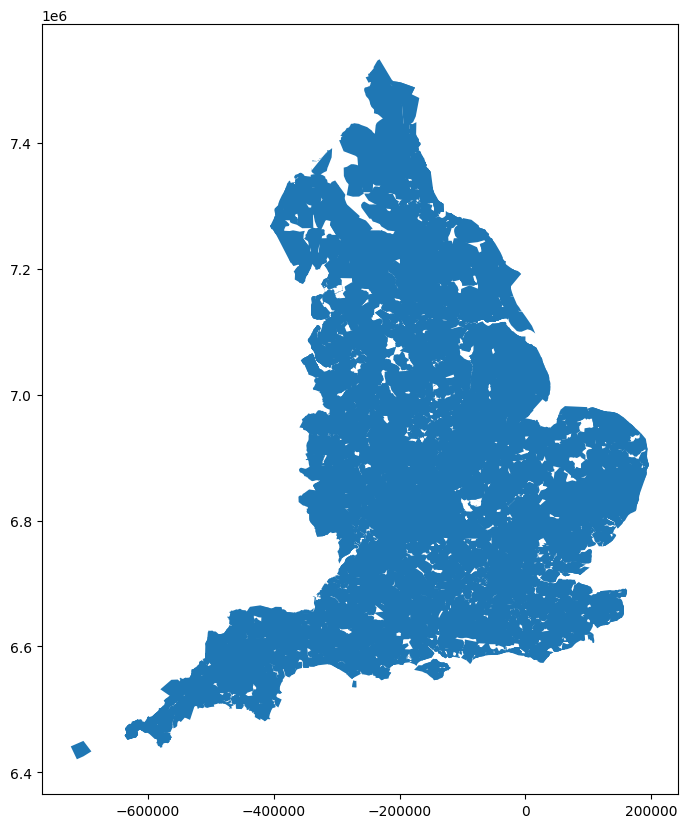

In [24]:
LADs_with_no_GPs = []
for i in range(len(LAD_GP_catchment_area_interesections)):
    if len(LAD_GP_catchment_area_interesections[i]) == 0:
        LAD_i = merc_gdf_LAD.index[i]
        LADs_with_no_GPs.append(LAD_i)
      
fig, ax = plt.subplots(figsize=(10,10))
merc_gdf_catchment.plot(ax=ax)
merc_gdf_LAD.loc[LADs_with_no_GPs,'geometry'].plot(ax=ax, color='red', alpha=0.5)

Compute the population $I_{ik}$ of the intersection of LAD $i$ and GP $k$

In [25]:
gdf_LAD.area

/var/folders/4n/x6w1yfcx01qbymrsfpz4ybq00000gn/T/ipykernel_11441/890124245.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_LAD.area


0      0.013057
1      0.007484
2      0.034046
3      0.028478
4      0.027434
         ...   
304    0.005661
305    0.002561
306    0.005035
307    0.004432
308    0.002783
Length: 309, dtype: float64

In [26]:
polygon_area(gdf_LAD.iloc[0]['geometry'])

93572024.79840297

In [27]:
intersection_data = LAD_GP_catchment_area_interesections[0]
intersection_data[0][1]

154.81084533716708

In [28]:
gdf_LAD = gdf_LAD.to_crs(epsg=3857)

In [29]:
###### my version ######

j = 0
for i in range(len(gdf_LAD)):
#for i, LAD_row in gdf_LAD.iterrows():
    intersection_data = LAD_GP_catchment_area_interesections[j]; j += 1
    #LAD_area = polygon_area(LAD_row['geometry'])
    
    for k in range(len(intersection_data)):
        #GP_i = intersection_data[k][0]
        int_area = intersection_data[k][1]
        LAD_area = merc_gdf_LAD.iloc[i].area
        #int_per = (int_area / LAD_areas[i]) 
        int_pop = (int_area / LAD_area) * gdf_LAD.iloc[i]['all_age']
        #intersection_data[k].append(int_per)
        intersection_data[k].append(int_pop)


#print(int/merc_gdf_LAD.iloc[0].area) 

# ### Compute $\sum_j I_{jk}$, used for computing $Z_i^\text{LSOA}$ and $L_i^\text{LSOA}$.

# GPs_covered_area = np.full(np.max(gdf_catchment.index+1), -1, dtype=float)

# print(len(GPs_covered_area))

# for intersection_data in LAD_GP_catchment_area_interesections:
#     for GP_i, GP_intersection_area, GP_intersection_num_patients in intersection_data:
#         if GPs_covered_area[GP_i] == -1:
#             GPs_covered_area[GP_i] = 0
#         GPs_covered_area[GP_i] += GP_intersection_area

## Overlapping GP catchment areas

I think it's worth noting that there is sometimes considerable overlap between gP catchment areas. This might be becuase one of the GP practices has closed down - this should become clear when the information is merged with QOF data. 

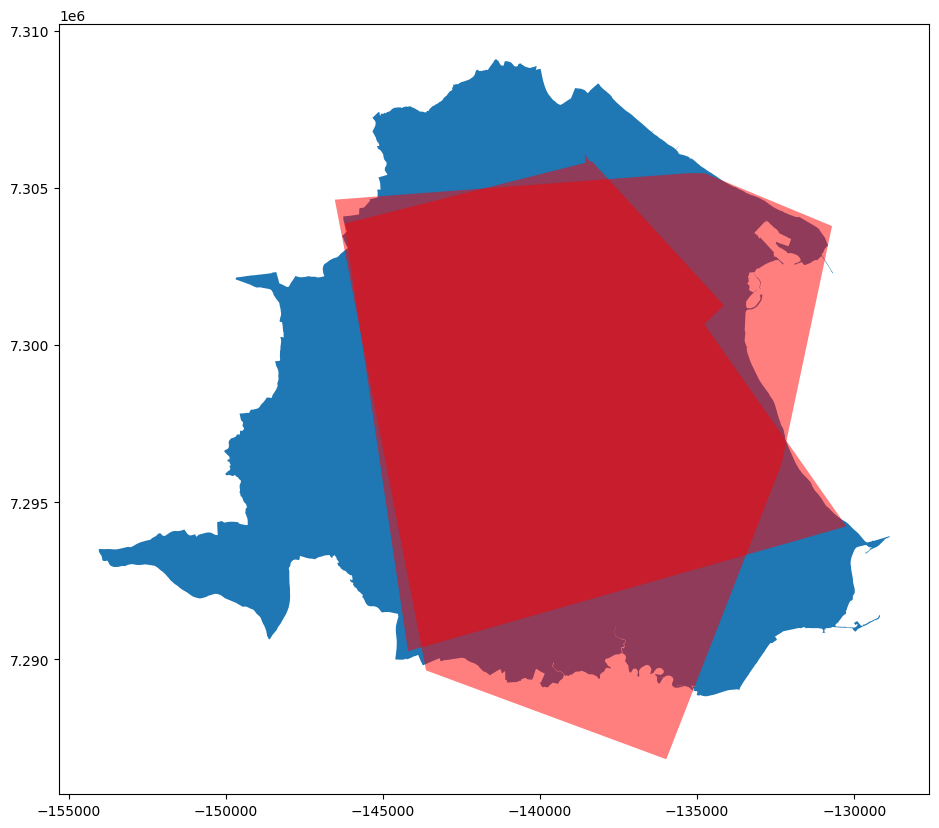

In [40]:
fig, ax = plt.subplots(figsize=(12,10))
gdf_LAD.loc[[0], 'geometry'].plot(ax=ax, linewidth=0.5, alpha=1.0)
gdf_catchment.loc[[7232], 'geometry'].plot(ax=ax, color='red', linewidth=0.5, alpha=0.5)
gdf_catchment.loc[[7223], 'geometry'].plot(ax=ax, color='red', linewidth=0.5, alpha=0.5)
#gdf_catchment.loc[[948],'geometry'].plot(ax=ax, color='red', alpha=0.5)
plt.show()

In [42]:
gdf_LAD.iloc[0]

OBJECTID                                                    1
LAD21CD                                             E06000001
LAD21NM                                            Hartlepool
LAD21NMW                                                     
BNG_E                                                  447160
BNG_N                                                  531474
LONG                                                 -1.27018
LAT                                                  54.67614
GlobalID                 cb7275ce-d16e-45f7-8e7d-33032fb9df9d
geometry    MULTIPOLYGON (((-136333.24996483803 7289637.24...
LAD_name                                           Hartlepool
all_age                                            92612.0236
Name: 0, dtype: object

In [41]:
gdf_catchment.iloc[[7232, 1610, 7223]]

,index,stroke-opacity,Name,Region,SubICBCode,ICBCode,ODSCode,fill-opacity,stroke,OrgLongitude,OrgLatitude,geometry,DCORegion,CCGCode,area
7236,0,1.0,L82051002 - BUGLE SURGERY,Y58,11N,QT6,L82051002,0.0,#FF901E,,,"POLYGON ((-550958.009 6511823.410, -551150.257...",NaN,NaN,3.217494e+13
1613,1,1.0,J83023 -,Y58,NaN,NaN,J83023,0.0,#0000FF,-1.812065,51.294101,"POLYGON ((-201640.786 6691717.677, -200341.688...",Q86,99N,4.505107e+13
7227,0,1.0,B81016 - PELHAM MEDICAL GROUP,Y54,NaN,NaN,B81016,0.0,#0000FF,-0.091276,53.563133,"POLYGON ((-15822.952 7091140.587, -16280.476 7...",Q72,03H,6.062421e+13


In [31]:
LAD_GP_catchment_area_interesections[0]

[[7232, 154.81084533716708, 51241.009004375126],
 [1610, 168.86601043489281, 55893.14328968308],
 [7223, 185.28498667506534, 61327.67797963297],
 [7963, 189.60302197291062, 62756.90914942738],
 [2657, 214.43615125571418, 70976.45344824952],
 [4877, 205.85797876224507, 68137.15486408627],
 [1921, 169.22927289128143, 56013.37992270592],
 [8900, 146.9007454879619, 48622.83650673216],
 [6066, 165.8529127532365, 54895.834831735236],
 [8901, 1.3859965752148822, 458.7525042960822],
 [8647, 181.03554560682124, 59921.150888025004],
 [1611, 35.90296664994265, 11883.56173229818],
 [4835, 0.14845938555753035, 49.13873246780255],
 [8899, 2.0507976344427394, 678.7957253496294],
 [2776, 28.950216305437117, 9582.263381836634],
 [3312, 28.950216305437117, 9582.263381836634],
 [1131, 0.3850899095433539, 127.46132533175721],
 [6057, 3.3372006840025574, 1104.5836609570383],
 [6035, 13.276647451350225, 4394.451888179323],
 [9784, 4.14582548490908, 1372.231257701118],
 [266, 1.8595415225017464, 615.49165816

In [32]:
gdf_LAD.iloc[0]

OBJECTID                                                    1
LAD21CD                                             E06000001
LAD21NM                                            Hartlepool
LAD21NMW                                                     
BNG_E                                                  447160
BNG_N                                                  531474
LONG                                                 -1.27018
LAT                                                  54.67614
GlobalID                 cb7275ce-d16e-45f7-8e7d-33032fb9df9d
geometry    MULTIPOLYGON (((-136333.24996483803 7289637.24...
LAD_name                                           Hartlepool
all_age                                            92612.0236
Name: 0, dtype: object

In [33]:
len(intersection_data)

68

In [34]:
intersection_data

[[5020, 55.113906799122525, 202244.70216835316],
 [6682, 54.05583260765262, 198362.01788495088],
 [6300, 8.015941582110193, 29415.11157577029],
 [5106, 7.730895222781226, 28369.112128538614],
 [9173, 30.318067518313956, 111254.47081641201],
 [5338, 3.7802247210362596, 13871.824140900795],
 [1101, 10.582199804976632, 38832.19267405624],
 [4480, 23.31946530255706, 85572.56396340218],
 [4645, 5.029722297502125, 18456.951196644943],
 [8792, 8.34655452326714, 30628.321084959978],
 [490, 11.510874916422743, 42240.03712264778],
 [9170, 16.155873342523012, 59285.214607218244],
 [7645, 37.16856940832044, 136392.9121810906],
 [3982, 28.297747871056586, 103840.75313470805],
 [4167, 15.067593830492168, 55291.6895865949],
 [7089, 5.614952297544199, 20604.497504510364],
 [9197, 9.742331317824227, 35750.23093500152],
 [774, 1.1098381916202662, 4072.6362465539833],
 [6493, 16.190078281958726, 59410.73225223071],
 [4876, 2.04671783424345, 7510.587850684064],
 [7085, 6.111506032957386, 22426.63946761326

In [35]:
j = 0
for i, LAD_row in gdf_LAD.iterrows():
    intersection_data = LAD_GP_catchment_area_interesections[j]; j += 1
    #LAD_area = polygon_area(LAD_row['geometry'])
    LAD_area = polygon_area(LAD_row['geometry'])
    
    for k in range(len(intersection_data)):
        #GP_i = intersection_data[k][0]
        int_area = intersection_data[k][1]
        int_pop = (int_area / LAD_area) * LAD_row['all_age']
        intersection_data[k].append(int_pop)

# ### Compute $\sum_j I_{jk}$, used for computing $Z_i^\text{LSOA}$ and $L_i^\text{LSOA}$.

# GPs_covered_area = np.full(np.max(gdf_catchment.index+1), -1, dtype=float)

# print(len(GPs_covered_area))

# for intersection_data in LAD_GP_catchment_area_interesections:
#     for GP_i, GP_intersection_area, GP_intersection_num_patients in intersection_data:
#         if GPs_covered_area[GP_i] == -1:
#             GPs_covered_area[GP_i] = 0
#         GPs_covered_area[GP_i] += GP_intersection_area

In [36]:
intersection_data

[[5020, 55.113906799122525, 202244.70216835316, -3.1622478051088247e-09],
 [6682, 54.05583260765262, 198362.01788495088, -3.1015391204239762e-09],
 [6300, 8.015941582110193, 29415.11157577029, -4.5992736037199394e-10],
 [5106, 7.730895222781226, 28369.112128538614, -4.4357237346410456e-10],
 [9173, 30.318067518313956, 111254.47081641201, -1.7395472038366885e-09],
 [5338, 3.7802247210362596, 13871.824140900795, -2.168963882470649e-10],
 [1101, 10.582199804976632, 38832.19267405624, -6.071704956151495e-10],
 [4480, 23.31946530255706, 85572.56396340218, -1.3379913029590656e-09],
 [4645, 5.029722297502125, 18456.951196644943, -2.885882932152477e-10],
 [8792, 8.34655452326714, 30628.321084959978, -4.788968021741268e-10],
 [490, 11.510874916422743, 42240.03712264778, -6.604547028758188e-10],
 [9170, 16.155873342523012, 59285.214607218244, -9.269688538541954e-10],
 [7645, 37.16856940832044, 136392.9121810906, -2.1326056136591573e-09],
 [3982, 28.297747871056586, 103840.75313470805, -1.6236281

Save data

In [37]:
LAD_GP_catchment_area_interesections = np.array(LAD_GP_catchment_area_interesections, dtype=object)
#np.save('data/LAD_GP_intersections/LAD_GP_intersections_2020.npy', LAD_GP_catchment_area_interesections)